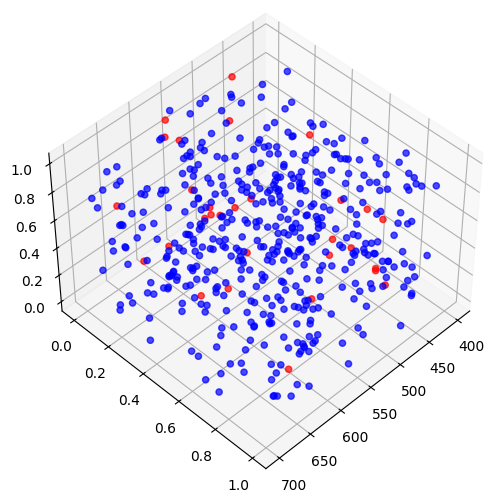

In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def latin_hypercube_sampling(num_samples, num_dimensions, bounds=None, seed=None):
    """
    Generate Latin Hypercube Sampling (LHS) points.
    
    Parameters:
    - num_samples (int): Number of sample points to generate.
    - num_dimensions (int): Number of dimensions (features).
    - bounds (list of tuples, optional): List of (min, max) for each dimension. Default is (0,1) for all.
    
    Returns:
    - samples (numpy.ndarray): LHS sample points of shape (num_samples, num_dimensions).
    """
    # Create an LHS sampler
    sampler = qmc.LatinHypercube(d=num_dimensions, seed=seed)
    samples = sampler.random(n=num_samples)
    
    # Scale the samples to the given bounds
    if bounds:
        lower_bounds, upper_bounds = np.array(bounds).T
        samples = qmc.scale(samples, lower_bounds, upper_bounds)
    
    return samples

def select_random_indices(total_size, subset_size, seed=None):
    """
    Randomly select a subset of indices from a given range.
    
    Parameters:
    - total_size (int): The total number of available indices.
    - subset_size (int): The number of indices to randomly select.
    - seed (int, optional): Random seed for reproducibility.
    
    Returns:
    - selected_indices (numpy.ndarray): Array of randomly selected indices.
    - not_selected_indices (numpy.ndarray): Array of indices that were not selected.
    """
    if seed is not None:
        np.random.seed(seed)
    selected_indices = np.random.choice(total_size, subset_size, replace=False)
    not_selected_indices = np.setdiff1d(np.arange(total_size), selected_indices)
    return selected_indices, not_selected_indices


num_samples = 500  # Number of points
num_dimensions = 3  # Number of input dimensions
bounds = [(400,700), (0,1), (0,1)]  # Custom bounds for each dimension
seed = 42

lhs_samples = latin_hypercube_sampling(num_samples, num_dimensions, bounds, seed)
selected, not_selected = select_random_indices(num_samples, 30, seed)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(lhs_samples[selected, 0], lhs_samples[selected, 1], lhs_samples[selected, 2], c='r', marker='o', alpha=0.7)
ax.scatter(lhs_samples[not_selected, 0], lhs_samples[not_selected, 1], lhs_samples[not_selected, 2], c='b', marker='o', alpha=0.7)
ax.view_init(elev=45, azim=45)

In [2]:
print(lhs_samples[selected,:])
np.savetxt('lhs_init_to_label_sim_params.csv', lhs_samples[selected,:], delimiter=',', header=f"# seed={seed}\n" + "Laser Power, Material Start, Material End", comments='')

[[4.39694006e+02 5.48043591e-01 4.52510017e-01]
 [4.62761453e+02 2.13981026e-02 9.37022832e-01]
 [4.57700482e+02 7.97647287e-01 2.41153009e-01]
 [4.80580134e+02 5.02701534e-01 9.96118811e-01]
 [5.76260458e+02 8.31264976e-01 4.37267215e-01]
 [6.20748411e+02 5.31647417e-01 3.61649307e-01]
 [5.22690124e+02 2.11809602e-01 9.62544313e-01]
 [6.51781485e+02 3.17371120e-01 5.63684777e-01]
 [6.15991638e+02 3.61540688e-01 1.25736356e-01]
 [4.32523150e+02 6.66324566e-01 4.73431206e-01]
 [4.55773718e+02 9.96914210e-02 1.00633902e-01]
 [5.43937012e+02 3.09202895e-01 4.98165325e-01]
 [4.36794009e+02 6.01867842e-01 1.39997865e-01]
 [5.53927662e+02 3.75043209e-02 7.65526675e-01]
 [5.30840260e+02 1.26038358e-01 2.35860719e-01]
 [5.66711882e+02 4.52278398e-01 3.74353751e-01]
 [5.76969500e+02 4.60372258e-02 9.81061990e-01]
 [6.54308613e+02 9.66607359e-01 3.23107687e-01]
 [4.93675255e+02 9.55321356e-01 3.88938299e-01]
 [4.68896824e+02 8.56219472e-01 6.89060088e-01]
 [4.51637998e+02 7.79624193e-01 1.877853

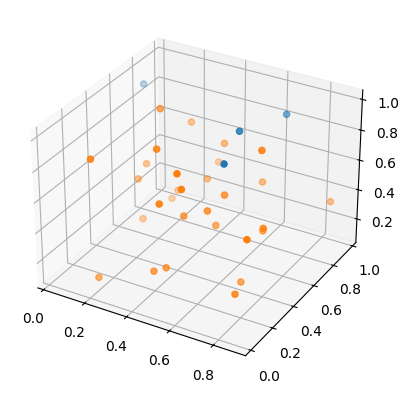

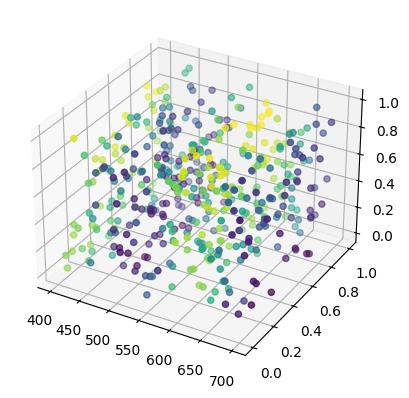

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sample scatter points
points = lhs_samples[selected,:]

def closest_points_finder(ref_points, to_classify, max_find_num = 5, classify_data = None):
    ref_points_norm = ref_points
    ref_points_norm[:,0] = (ref_points_norm[:,0] - 400)/300
    to_classify_norm = to_classify
    to_classify_norm[:,0] = (to_classify_norm[:,0] - 400)/300
    closest_point_dist = np.zeros(len(to_classify[:,0]))
    for i in range(len(to_classify[:,0])):
        distance_to_points = np.linalg.norm(ref_points_norm - to_classify_norm[i,:], axis = 1)
        closest_point_dist[i] = np.min(distance_to_points)

    if classify_data is None:
        classify_data = closest_point_dist
    
    max_point = np.zeros(max_find_num)
    max_point[0] = np.max(classify_data)
    max_var = np.zeros([max_find_num,3])
    max_ind = np.argmax(classify_data)
    max_dist = closest_point_dist[max_ind]
    max_var[0,:] = to_classify_norm[max_ind, :]
    distance_to_max = np.linalg.norm(to_classify_norm - max_var[0,:], axis = 1)
    rest_var_to_classify = to_classify_norm[distance_to_max > max_dist,:]
    rest_data_to_classify = classify_data[distance_to_max > max_dist]
    dist_to_comp = closest_point_dist[distance_to_max > max_dist]
    for i in range(max_find_num - 1):
        max_point[i+1] = np.max(rest_data_to_classify)
        max_ind = np.argmax(rest_data_to_classify)
        max_dist = dist_to_comp[max_ind]
        max_var[i+1,:] = rest_var_to_classify[max_ind,:]
        distance_to_max = np.linalg.norm(rest_var_to_classify - max_var[i+1,:], axis = 1)
        rest_var_to_classify = rest_var_to_classify[distance_to_max > max_dist, :]
        rest_data_to_classify = rest_data_to_classify[distance_to_max > max_dist]
        dist_to_comp = dist_to_comp[distance_to_max > max_dist]
    
    return max_point, max_var

test_data = lhs_samples[not_selected,2]/(1+np.exp(-5*lhs_samples[not_selected,1])) + 2*np.cos(3*np.pi*(lhs_samples[not_selected,0] - 400)/300)
max_point, max_var = closest_points_finder(points,lhs_samples[not_selected,:],4,test_data)
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(max_var[:,0], max_var[:,1], max_var[:,2])
ax.scatter(points[:,0], points[:,1], points[:,2])

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(lhs_samples[not_selected,0],lhs_samples[not_selected,1],lhs_samples[not_selected,2],c = test_data)